<a href="https://colab.research.google.com/github/rakshith3101/next-binge-movie-recommendations-/blob/main/movie_recomendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***NEXT BINGE* (MOVIE RECOMENDATION SYSTEM)**



Greetings, My name is Rakshith Srinivasan I've chosen mobile recommendation system(option 1) for my selection assessment.I'm confident that this approach will be convincing.

The movie recommendation system with a hybrid model utilizes data imported from Kaggle, combining collaborative filtering and content-based filtering approaches to provide accurate predictions and diverse movie suggestions for an enhanced user experience.


*   [Dataset Link:](https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies)



In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download akshaypawar7/millions-of-movies

 93% 153M/164M [00:01<00:00, 98.0MB/s]
100% 164M/164M [00:01<00:00, 93.3MB/s]


In [ ]:
! unzip millions-of-movies.zip -d millions-of-movies

Archive:  millions-of-movies.zip
  inflating: millions-of-movies/movies.csv  


# IMPORTING PACKAGE

In here we import all the packages that are necessary to compute.

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate
import functools
import ipywidgets as widgets
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
dataframe=pd.read_csv("/content/millions-of-movies/movies.csv")

# DATA VISUALIZATION

Below shown is the visualization of imported data.It basically has 20 metadata (ie. title, genres,language , production_company, crew and cast etc) including the movie poster link. This dataset is the updated version where recently launched movies are added in. This whole structure of this dataset ease to achieve higher accuracy.This entire section provides the overview of data and the operations performed on it.

In [ ]:
dataframe.head(5)

In [ ]:
#contains 722753 rows and 20 columns
dataframe.shape

(722753, 20)

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722753 entries, 0 to 722752
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    722753 non-null  int64  
 1   title                 722749 non-null  object 
 2   genres                511933 non-null  object 
 3   original_language     722753 non-null  object 
 4   overview              604180 non-null  object 
 5   popularity            722753 non-null  float64
 6   production_companies  337182 non-null  object 
 7   release_date          670374 non-null  object 
 8   budget                722753 non-null  float64
 9   revenue               722753 non-null  float64
 10  runtime               688309 non-null  float64
 11  status                722753 non-null  object 
 12  tagline               108123 non-null  object 
 13  vote_average          722753 non-null  float64
 14  vote_count            722753 non-null  float64
 15  

In [ ]:
# deleting all the duplicated dataframe rows
dataframe.isnull().sum()
dataframe.drop_duplicates(inplace=True)

In [ ]:
# we ignore repeated movies
dataframe[['title','release_date']].duplicated().sum()
dataframe.drop_duplicates(subset=['title','release_date'],inplace=True)

In [ ]:
# considering genres and overviews as the key predict, we fill up the null value
dataframe.fillna('',inplace=True)
null_value=dataframe[(dataframe['genres']=='') & (dataframe['overview']=='')].index
dataframe.drop(null_value,inplace=True)

dataframe.isnull().sum() # we obtain no duplication

id                      0
title                   0
genres                  0
original_language       0
overview                0
popularity              0
production_companies    0
release_date            0
budget                  0
revenue                 0
runtime                 0
status                  0
tagline                 0
vote_average            0
vote_count              0
credits                 0
keywords                0
poster_path             0
backdrop_path           0
recommendations         0
dtype: int64

Text(0.5, 1.0, 'Popular Movies')

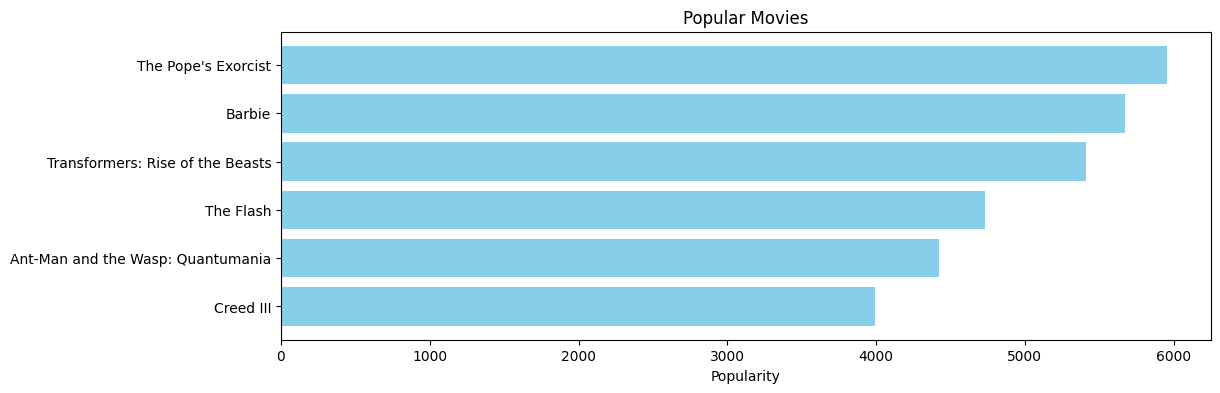

In [ ]:
# Bar graph, Popularity vs Title
pop= dataframe.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


Text(0.5, 1.0, 'vote count of few movies')

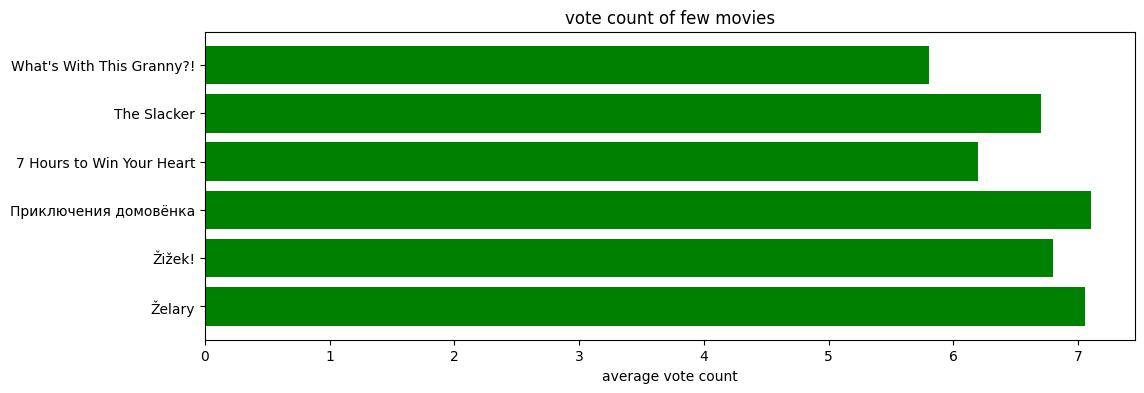

In [ ]:
#bar graph , title vs vote_average
pop= dataframe.sort_values('title', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.barh(pop['title'].head(6),pop['vote_average'].head(6), align='center',color='green')
plt.gca().invert_yaxis()
plt.xlabel("average vote count")
plt.title("vote count of few movies")


# PREPROCESSING

Data Preprocessing is one of the important task to perform in any machine learning or deep learning algorithm. Here in this section we preprocess the data by applying parameters to vote_mean and vote_percentile. We then calculate the weighted_average( explained below ) and create a new column "Score". Further we consider features to produce precise predictions.

In [ ]:
vote_mean=dataframe['vote_average'].mean() #calculating mean value of the voting for a particular movie
vote_percentile=dataframe['vote_count'].quantile(0.9) # calculating the percentile of vote obtained
vote_mean,vote_percentile

(2.4440652625807338, 11.0)

We can't consider movies which high rating with less people voting for it, so according to IMDb Weighted Average function the right approach is to consider the percentile and mean of votes. The equaltion of this is show below:
            (v/(v+vote_percentile)*R)+(vote_percentile/(vote_percentile+v)*vote_mean)

[IMDb Weighted Average](https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website)

Now we have the most accurate rating of each movie

In [ ]:
def weighted_average(X,vote_mean=vote_mean,vote_percentile=vote_percentile):
    R=X['vote_average']
    v=X['vote_count']
    return round((v/(v+vote_percentile)*R)+(vote_percentile/(vote_percentile+v)*vote_mean))

In [ ]:
# consider movies having vote_count more that 20
dataframe = dataframe[dataframe.vote_count>=20].reset_index()
dataframe.shape

(44962, 21)

In [ ]:
# adding column "score" into the dataframe
dataframe['score']=dataframe.apply(weighted_average,axis=1)
dataframe['score']

0        7
1        8
2        7
3        7
4        6
        ..
44957    5
44958    6
44959    7
44960    7
44961    3
Name: score, Length: 44962, dtype: int64

In [ ]:
# In here we remove noise ('-') from each column in the dataframe.
# we do this for genres,overview,credits,keywords
dataframe['genres']=dataframe['genres'].apply(lambda i:' '.join(i.split('-')))
dataframe['overview']=dataframe['overview'].apply(lambda i:' '.join(i.split('-')))
dataframe['credits']=dataframe['credits'].apply(lambda i:' '.join(i.split('-')[:5]))
dataframe['keywords']=dataframe['keywords'].apply(lambda i:' '.join(i.split('-')))

In [ ]:
# We consider only genres,overview,credits,keywords as our features
dataframe['features']=dataframe['genres']+' '+ dataframe['overview']+' ' + dataframe['credits']+' '+dataframe['keywords']
dataframe['features'][3]

"Action Adventure Science Fiction When his attempt to save his family inadvertently alters the future Barry Allen becomes trapped in a reality in which General Zod has returned and there are no Super Heroes to turn to. In order to save the world that he is in and return to the future that he knows Barry's only hope is to race for his life. But will making the ultimate sacrifice be enough to reset the universe? Ezra Miller Sasha Calle Michael Keaton Michael Shannon Ron Livingston secret identity hero superhero based on comic superhuman super power aftercreditsstinger butterfly effect dc extended universe (dceu) superhuman abilities loss of mother"

In [ ]:
# remove noise
dataframe['features']=dataframe['features'].str.replace('[^\w\s]','')
dataframe['features'][3]

<ipython-input-149-c46d0fe3fbd5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe['features']=dataframe['features'].str.replace('[^\w\s]','')


'Action Adventure Science Fiction When his attempt to save his family inadvertently alters the future Barry Allen becomes trapped in a reality in which General Zod has returned and there are no Super Heroes to turn to In order to save the world that he is in and return to the future that he knows Barrys only hope is to race for his life But will making the ultimate sacrifice be enough to reset the universe Ezra Miller Sasha Calle Michael Keaton Michael Shannon Ron Livingston secret identity hero superhero based on comic superhuman super power aftercreditsstinger butterfly effect dc extended universe dceu superhuman abilities loss of mother'

# CONTENT BASED FILTERING

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.The approach can be used in various domains, such as movies, music, books, and products, where items have well-defined attributes.

In [ ]:
# using tfidf vectorizer to vectorize the feature value.
# This converts english words into numerical values.
tfidf=TfidfVectorizer(stop_words='english')
tfidf_vector=tfidf.fit_transform(dataframe['features'])

print(tfidf_vector)

  (0, 97352)	0.0993179995386393
  (0, 480)	0.11061342648948395
  (0, 79769)	0.11088986385557996
  (0, 17706)	0.12223553236711261
  (0, 92856)	0.1660975904322981
  (0, 26904)	0.11797388925925338
  (0, 77602)	0.1293169263079736
  (0, 78848)	0.14374914136512434
  (0, 49743)	0.10046679237938015
  (0, 85738)	0.11351532018249452
  (0, 94487)	0.11066839016751498
  (0, 26636)	0.19982754549296616
  (0, 76980)	0.08457133456128621
  (0, 70763)	0.14649217296471423
  (0, 36800)	0.11532875777344388
  (0, 32800)	0.18677901768985178
  (0, 3326)	0.10072467375939761
  (0, 112272)	0.1902112294475497
  (0, 24667)	0.09333130964769219
  (0, 23506)	0.14686495834146518
  (0, 86646)	0.10949477784469971
  (0, 45000)	0.10575479280630032
  (0, 102608)	0.13778326372030508
  (0, 26652)	0.12233756538845636
  (0, 21882)	0.21707387674634163
  :	:
  (44961, 7591)	0.14228078357722646
  (44961, 104158)	0.11785104272622074
  (44961, 100426)	0.0979571457234379
  (44961, 44355)	0.120828189113882
  (44961, 104498)	0.11768876

In [ ]:
tfidf_vector.shape

(44962, 113001)

Formula used in Content-Based Filtering:
To calculate the similarity between items, the system typically employs a similarity metric such as cosine similarity or Euclidean distance. Let's consider cosine similarity for item A and item B:

Cosine Similarity between items A and B:
Cosine_Similarity(A, B) = (A ⋅ B) / (||A|| * ||B||)

#COLABORATIVE FILTERING

Collaborative filtering is a recommendation technique that identifies patterns in user-item interactions and leverages the behavior of multiple users to make personalized recommendations. It focuses on finding similarities between users or items based on their historical interactions to suggest items that users with similar tastes have enjoyed.We use surprise module for this purpose

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811638 sha256=a76080bc226e69e8975346f173c75e8d788ab9264d18461539c432c65bfcc083
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


SVD stands for Singular Value Decomposition, and it is a mathematical technique used in various applications, including recommendation systems, image processing, data compression, and more. In

In [ ]:
reader = Reader(rating_scale=(1, 10)) #rating ranging from 1-10
data = Dataset.load_from_df(dataframe[['id', 'title', 'score']], reader)
trainset, testset = train_test_split(data, test_size=0.2)
colab_filt = SVD()
cross_validate(colab_filt, data, measures=['RMSE', 'MAE'],cv=5,verbose=True) # model evaluation

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0104  1.0223  1.0251  1.0132  1.0237  1.0189  0.0060  
MAE (testset)     0.8264  0.8328  0.8393  0.8270  0.8390  0.8329  0.0056  
Fit time          0.59    0.69    0.58    0.61    0.60    0.61    0.04    
Test time         0.04    0.04    0.04    0.04    0.05    0.04    0.00    


{'test_rmse': array([1.01037949, 1.0223365 , 1.02513645, 1.01316548, 1.02368071]),
 'test_mae': array([0.82639918, 0.83275017, 0.83933859, 0.82700323, 0.83902893]),
 'fit_time': (0.58522629737854,
  0.6937239170074463,
  0.5847275257110596,
  0.6113898754119873,
  0.5971872806549072),
 'test_time': (0.04375147819519043,
  0.042978763580322266,
  0.044641733169555664,
  0.04196643829345703,
  0.0493621826171875)}

In [ ]:
colab_filt.fit(trainset)

#**HYBRID MODEL**

This is an unique approach where the profit of content based filtering and colaborative filtering are summed up into single model called hybrid model. This model takes in user_id and title of the movie and predict the movie recommended by both content and colaborative filtering.

In [ ]:
@functools.lru_cache(maxsize=None)
def hybrid_recommendations(user_id, title, n=5):
    movie_index = dataframe[dataframe['title'] == title].index[0]
    #content-based-filtering
    content_scores = list(enumerate(linear_kernel(tfidf_vector,tfidf_vector[movie_index])))
    content_scores = sorted(content_scores, key=lambda x: x[1], reverse=True)
    content_based_rec = [dataframe['title'].iloc[idx] for idx, _ in content_scores[2:n+1]]

    #collaborative filtering
    user_movie_titles = dataframe[dataframe['id'] == user_id]['title'].values
    user_movie_recs = [title for title in dataframe['title'].unique() if title not in user_movie_titles]
    collaborative_rec = [title for title in user_movie_recs if colab_filt.predict(user_id, title).est > 3.5][:n]
    #hybrid model
    return content_based_rec+collaborative_rec



user_id = 667538
movie_title = "Ant-Man and the Wasp: Quantumania"
recommendations = hybrid_recommendations(user_id, movie_title, n=6)
print("Hybrid Recommendations:")
for idx, movie in enumerate(recommendations, start=1):
    print(f"{idx}. {movie}")


Hybrid Recommendations:
1. Ant-Man
2. Spider-Man: No Way Home
3. Captain Marvel
4. Guardians of the Galaxy Vol. 3
5. Guardians of the Galaxy Vol. 2
6. The Pope's Exorcist
7. Barbie
8. The Flash
9. Ant-Man and the Wasp: Quantumania
10. Creed III
11. The Super Mario Bros. Movie


# USER INTERFACE USING IPY WIDGETS

I made an attempt to put this in a small user interface model ie ipywidgets . This frame has two buttons one for movie selection and other for recommendations. On passing the title the model makes best recommendations possible.

In [ ]:
def display_recommendations(btn):
    user_id = 502356
    movie_title = random_movie
    n_recommendations = 6

    # Get the top N hybrid recommendations
    hybrid_rec = hybrid_recommendations(user_id, movie_title, n=n_recommendations)

    # Display the recommendations in the output frame
    recommendations_output.clear_output()
    with recommendations_output:
        print("Movie Recommendations:")
        for idx, movie in enumerate(hybrid_rec, start=1):
            print(f"{idx}. {movie}")

# button to select a random movie image
random_movie_button = widgets.Button(description="Select Random Movie")

# button for movie recommendations
recommend_button = widgets.Button(description="Give Recommendation")

# output frame to display recommendations
recommendations_output = widgets.Output()

def random_movie_button_click(btn):
    global random_movie
    movie_titles = dataframe['title'].unique()
    random_movie = np.random.choice(movie_titles)
    base_domain = 'https://image.tmdb.org/t/p/w500'
    image_links = base_domain+dataframe.loc[dataframe['title'] == random_movie, 'poster_path'].iloc[0]


    image_widget = Image(url=image_links, width=200, height=300)
    display(image_widget)


random_movie_button.on_click(random_movie_button_click)
recommend_button.on_click(display_recommendations)
intro_text = widgets.HTML("<h2>Ahoy there, matey! Avast ye!</h2>")
random_movie_text = widgets.HTML("<p>Let's go grab some recommendations.</p>")

display(intro_text)
display(random_movie_text)
display(random_movie_button)
display(recommendations_output)
display(recommend_button)


HTML(value='<h2>Ahoy there, matey! Avast ye!</h2>')

HTML(value="<p>Let's go grab some recommendations.</p>")

Button(description='Select Random Movie', style=ButtonStyle())

Output()

Button(description='Give Recommendation', style=ButtonStyle())

In [ ]:
def display_recommendations(btn):
    user_id = 502356
    movie_title = random_movie
    n_recommendations = 6

    # Get the top N hybrid recommendations
    hybrid_rec = hybrid_recommendations(user_id, movie_title, n=n_recommendations)

    # Display the recommendations in the output frame
    recommendations_output.clear_output()
    with recommendations_output:
        print("Movie Recommendations:")
        for idx, movie in enumerate(hybrid_rec, start=1):
            print(f"{idx}. {movie}")

# button to select a random movie image
random_movie_button = widgets.Button(description="Select Random Movie")

# button for movie recommendations
recommend_button = widgets.Button(description="Give Recommendation")

# output frame to display recommendations
recommendations_output = widgets.Output()

def random_movie_button_click(btn):
    global random_movie
    movie_titles = dataframe['title'].unique()
    random_movie = np.random.choice(movie_titles)
    base_domain = 'https://image.tmdb.org/t/p/w500'
    image_links = base_domain+dataframe.loc[dataframe['title'] == random_movie, 'poster_path'].iloc[0]


    image_widget = Image(url=image_links, width=200, height=300)
    display(image_widget)


random_movie_button.on_click(random_movie_button_click)
recommend_button.on_click(display_recommendations)
intro_text = widgets.HTML("<h2>Ahoy there, matey! Avast ye!</h2>")
random_movie_text = widgets.HTML("<p>Let's go grab some recommendations.</p>")

display(intro_text)
display(random_movie_text)
display(random_movie_button)
display(recommendations_output)
display(recommend_button)


HTML(value='<h2>Ahoy there, matey! Avast ye!</h2>')

HTML(value="<p>Let's go grab some recommendations.</p>")

Button(description='Select Random Movie', style=ButtonStyle())

Output()

Button(description='Give Recommendation', style=ButtonStyle())